In [49]:
# pip install rdkit
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors, PandasTools
import seaborn as sns
import os
import random





In [50]:
# basics
import pprint as pp

# pandas is used to read/process data
import pandas as pd
from ydata_profiling import ProfileReport

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# train/test split
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression, SGDRegressor
# pipeline to streamline modeling pipelines
from sklearn.pipeline import Pipeline
# principal component analysis
from sklearn.decomposition import PCA
# polynomial kernel
from sklearn.metrics.pairwise import polynomial_kernel
# Dummy model as baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
# Variance Threshold for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# metrics to measure model performance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error)

# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import check_scoring
from sklearn.utils import Bunch
from sklearn.utils import check_random_state
from sklearn.utils import check_array

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

#EDA report
import ipywidgets


In [51]:
#load the Data Frame from Github repository
df = pd.read_csv("https://raw.githubusercontent.com/GjotoGjoto/1147/refs/heads/main/train.csv", storage_options={"verify_ssl": False})

#Checking dimensions and first few rows
print(f"Dataet Shape: {df.shape}")
print("First few rows:")
df.head()

Dataet Shape: (7973, 7)
First few rows:


id                                             SMILES  Tg       FFV  \
0   87817                         *CC(*)c1ccccc1C(=O)OCCCCCC NaN  0.374645   
1  106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5... NaN  0.370410   
2  388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(... NaN  0.378860   
3  519416  *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)... NaN  0.387324   
4  539187  *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N... NaN  0.355470   

         Tc  Density  Rg  
0  0.205667      NaN NaN  
1       NaN      NaN NaN  
2       NaN      NaN NaN  
3       NaN      NaN NaN  
4       NaN      NaN NaN

In [52]:
#Canonicalizing SMILES strings
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.MolToSmiles(mol)
    else:
        return None

# Apply the function to the SMILES column and create a new column with canonical SMILES
# If a SMILES string cannot be parsed, it will be set to None

df["canonical_smiles"] = df['SMILES'].apply(canonicalize_smiles)
changed = df[df["SMILES"] != df["canonical_smiles"]]
changed.head()
print(f"Total changed SMILES: {len(changed)}")



Total changed SMILES: 17


In [53]:
changed.head()

id                                             SMILES  Tg  \
41     10557152                              *C(C)=C(*)[Ge](C)(C)C NaN   
85     22928574                *O[Sn](CCCC)(CCCC)OC(=O)/C=C/C(*)=O NaN   
469   131094319                      *C=C[Ge](*)(c1ccccc1)c1ccccc1 NaN   
975   266479070  *CCC[Sn](C)(C)CCCOC(=O)C(CCCCCCOc1ccc(-c2ccc(O... NaN   
1847  499146119           *O[Sn](CCCC)(CCCC)OC(=O)c1ccc(C(*)=O)cc1 NaN   

           FFV  Tc  Density  Rg  \
41    0.399961 NaN      NaN NaN   
85    0.350276 NaN      NaN NaN   
469   0.393029 NaN      NaN NaN   
975   0.358964 NaN      NaN NaN   
1847  0.360807 NaN      NaN NaN   

                                       canonical_smiles  
41                  *C(C)=[C](*)[Ge]([CH3])([CH3])[CH3]  
85      *[O][Sn]([CH2]CCC)([CH2]CCC)[O]C(=O)/C=C/C(*)=O  
469              *C=[CH][Ge]([*])([c]1ccccc1)[c]1ccccc1  
975   *CC[CH2][Sn]([CH3])([CH3])[CH2]CCOC(=O)C(CCCCC...  
1847  *[O][Sn]([CH2]CCC)([CH2]CCC)[O]C(=O)c1ccc(C(*)...

In [54]:
unique_smiles = df["SMILES"].nunique()
unique_canonical_smiles = df["canonical_smiles"].nunique()
print(f"Unique SMILES: {unique_smiles}")
print(f"unique_canonical_smiles: {unique_canonical_smiles}")


Unique SMILES: 7973
unique_canonical_smiles: 7973


In [55]:

#adding column called "molecule" with mol object
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="canonical_smiles", molCol="molecule")

#adding descriptors
def calculate_key_descriptors(mol):
     MW = Descriptors.MolWt(mol)
     LogP = Descriptors.MolLogP(mol)
     TPSA = Descriptors.TPSA(mol)
     HBD = Descriptors.NumHDonors(mol)
     HBA = Descriptors.NumHAcceptors(mol)
     RotBonds = Descriptors.NumRotatableBonds(mol)
     rings = Descriptors.RingCount(mol)
     FractionCSP3 = rdMolDescriptors.CalcFractionCSP3(mol)
     labutsa = rdMolDescriptors.CalcLabuteASA(mol)
     MolMR = Descriptors.MolMR(mol)
     if mol:
        return MW, LogP, TPSA, HBD, HBA, RotBonds, rings, FractionCSP3, labutsa, MolMR
     else:
        return None, None, None, None, None, None, None, None, None, None
df[['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds','rings', 'FractionCSP3', 'labutsa', 'MolMR']] = df['molecule'].apply(lambda mol: pd.Series(calculate_key_descriptors(mol)))
df.head()
df.info()
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7973 non-null   int64  
 1   SMILES            7973 non-null   object 
 2   Tg                511 non-null    float64
 3   FFV               7030 non-null   float64
 4   Tc                737 non-null    float64
 5   Density           613 non-null    float64
 6   Rg                614 non-null    float64
 7   canonical_smiles  7973 non-null   object 
 8   molecule          7973 non-null   object 
 9   MW                7973 non-null   float64
 10  LogP              7973 non-null   float64
 11  TPSA              7973 non-null   float64
 12  HBD               7973 non-null   float64
 13  HBA               7973 non-null   float64
 14  RotBonds          7973 non-null   float64
 15  rings             7973 non-null   float64
 16  FractionCSP3      7973 non-null   float64


In [56]:
#dropping Tc, Density, Rg and Tg columns from neurips dataset that are not needed for our analysis
df = df.drop(columns=['Tc', 'Density', 'Rg', 'Tg'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7973 non-null   int64  
 1   SMILES            7973 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7973 non-null   object 
 4   molecule          7973 non-null   object 
 5   MW                7973 non-null   float64
 6   LogP              7973 non-null   float64
 7   TPSA              7973 non-null   float64
 8   HBD               7973 non-null   float64
 9   HBA               7973 non-null   float64
 10  RotBonds          7973 non-null   float64
 11  rings             7973 non-null   float64
 12  FractionCSP3      7973 non-null   float64
 13  labutsa           7973 non-null   float64
 14  MolMR             7973 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 934.5+ KB


In [57]:
#dropping rows with null values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 0 to 7972
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7030 non-null   int64  
 1   SMILES            7030 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7030 non-null   object 
 4   molecule          7030 non-null   object 
 5   MW                7030 non-null   float64
 6   LogP              7030 non-null   float64
 7   TPSA              7030 non-null   float64
 8   HBD               7030 non-null   float64
 9   HBA               7030 non-null   float64
 10  RotBonds          7030 non-null   float64
 11  rings             7030 non-null   float64
 12  FractionCSP3      7030 non-null   float64
 13  labutsa           7030 non-null   float64
 14  MolMR             7030 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 878.8+ KB


In [58]:
#dropping duplicate rows
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 0 to 7972
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7030 non-null   int64  
 1   SMILES            7030 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7030 non-null   object 
 4   molecule          7030 non-null   object 
 5   MW                7030 non-null   float64
 6   LogP              7030 non-null   float64
 7   TPSA              7030 non-null   float64
 8   HBD               7030 non-null   float64
 9   HBA               7030 non-null   float64
 10  RotBonds          7030 non-null   float64
 11  rings             7030 non-null   float64
 12  FractionCSP3      7030 non-null   float64
 13  labutsa           7030 non-null   float64
 14  MolMR             7030 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 878.8+ KB


In [59]:
#reviewing statistics of the dataframe
df.describe()


id          FFV           MW         LogP         TPSA  \
count  7.030000e+03  7030.000000  7030.000000  7030.000000  7030.000000   
mean   1.078609e+09     0.367212   457.872328     5.737188    68.446939   
std    6.207845e+08     0.029609   241.639330     3.736482    47.210870   
min    8.781700e+04     0.226992    14.027000    -4.822900     0.000000   
25%    5.436875e+08     0.349549   274.316000     3.118100    26.300000   
50%    1.076305e+09     0.364264   422.565000     5.208770    58.200000   
75%    1.621402e+09     0.380790   597.487500     7.692075    97.360000   
max    2.147438e+09     0.777097  2202.482000    27.557340   437.260000   

               HBD          HBA     RotBonds        rings  FractionCSP3  \
count  7030.000000  7030.000000  7030.000000  7030.000000   7030.000000   
mean      0.905405     4.573826     8.846942     3.940114      0.314885   
std       1.260725     2.908115     6.129783     3.083736      0.304052   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.000000     2.000000     5.000000     1.000000      0.052632   
50%       0.000000     4.000000     7.000000     3.000000      0.230769   
75%       2.000000     6.000000    11.000000     6.000000      0.482759   
max       8.000000    45.000000    92.000000    18.000000      1.000000   

           labutsa        MolMR  
count  7030.000000  7030.000000  
mean    195.850928   127.535836  
std     102.796161    68.290252  
min       8.739251     4.807000  
25%     117.950467    75.811250  
50%     181.902795   119.552200  
75%     256.109705   166.695000  
max     950.199587   615.918000

length of desc: 11


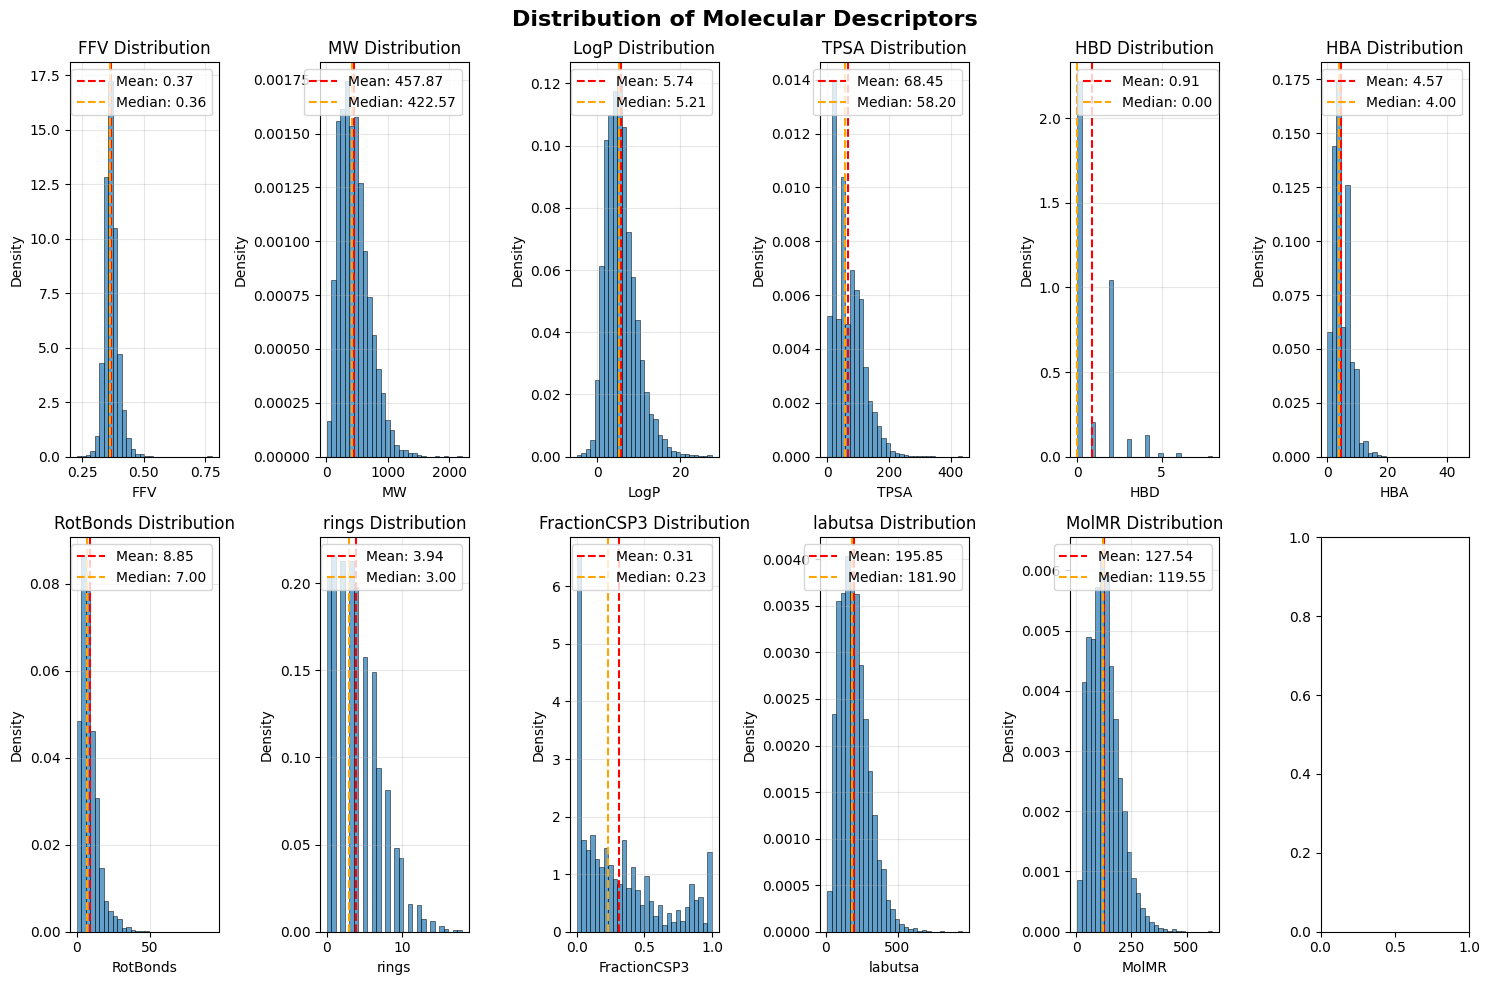

In [60]:
# Create visualizations for molecular descriptors
# Ensure all descriptor columns exist and drop rows with NaN in these columns

descriptors_to_plot = ['FFV', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA','RotBonds', 'rings','FractionCSP3', 'labutsa', 'MolMR']
for desc in descriptors_to_plot:
    if desc not in df.columns:
        print(f"Warning: Column '{desc}' not found in DataFrame. It will be skipped.")
descriptors_to_plot = [desc for desc in descriptors_to_plot if desc in df.columns]
print(f"length of desc: {len(descriptors_to_plot)}")
df_plot = df.dropna(subset=descriptors_to_plot)
# df.info()
fig, axes = plt.subplots(2, 6, figsize=(15, 10))
fig.suptitle('Distribution of Molecular Descriptors', fontsize=16, fontweight='bold')

for i, descriptor in enumerate(descriptors_to_plot):
    row = i // 6
    col = i % 6
    if row < 2 and col < 6:
        # Create histogram with density curve
        axes[row, col].hist(df_plot[descriptor], bins=30, alpha=0.7,
                           density=True, edgecolor='black', linewidth=0.5)

        # Add statistical information
        mean_val = df_plot[descriptor].mean()
        median_val = df_plot[descriptor].median()
        axes[row, col].axvline(mean_val, color='red', linestyle='--',
                              label=f'Mean: {mean_val:.2f}')
        axes[row, col].axvline(median_val, color='orange', linestyle='--',
                              label=f'Median: {median_val:.2f}')

        axes[row, col].set_title(f'{descriptor} Distribution')
        axes[row, col].set_xlabel(descriptor)
        axes[row, col].set_ylabel('Density')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/descriptors_histograms.png', dpi=300)
plt.show()


Correlation Matrix for Molecular Descriptors:
                FFV     MW   LogP   TPSA    HBD    HBA  RotBonds  rings  \
FFV           1.000  0.162  0.305 -0.216 -0.331 -0.148    -0.026  0.232   
MW            0.162  1.000  0.839  0.672  0.024  0.690     0.575  0.829   
LogP          0.305  0.839  1.000  0.255 -0.036  0.321     0.517  0.756   
TPSA         -0.216  0.672  0.255  1.000  0.261  0.915     0.443  0.482   
HBD          -0.331  0.024 -0.036  0.261  1.000  0.039    -0.012  0.064   
HBA          -0.148  0.690  0.321  0.915  0.039  1.000     0.543  0.468   
RotBonds     -0.026  0.575  0.517  0.443 -0.012  0.543     1.000  0.149   
rings         0.232  0.829  0.756  0.482  0.064  0.468     0.149  1.000   
FractionCSP3 -0.075 -0.425 -0.377 -0.292 -0.179 -0.253     0.164 -0.655   
labutsa       0.176  0.992  0.863  0.654  0.043  0.670     0.575  0.859   
MolMR         0.213  0.968  0.887  0.603  0.079  0.622     0.569  0.872   

              FractionCSP3  labutsa  MolMR  
FFV     

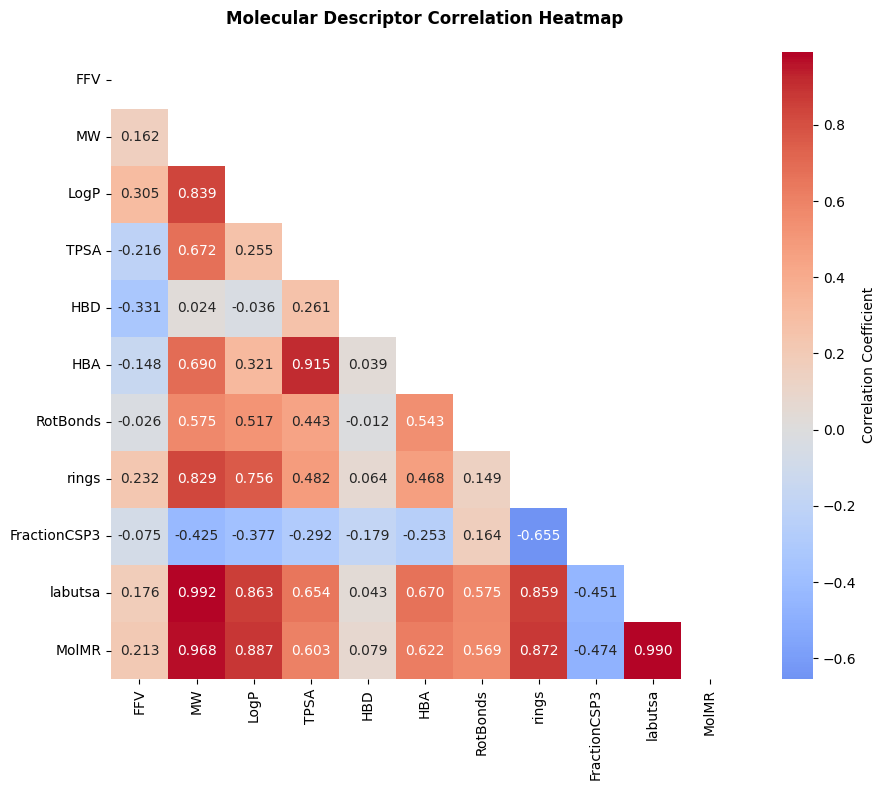

In [61]:
#HEATMAP
# Calculate correlation matrix for molecular descriptors
descriptor_cols = ['FFV', 'MW', 'LogP', 'TPSA', 'HBD', 'HBA','RotBonds', 'rings','FractionCSP3', 'labutsa', 'MolMR']

# Calculate correlation matrix using .corr()
correlation_matrix = df[descriptor_cols].corr()

# Display correlation matrix
print("Correlation Matrix for Molecular Descriptors:")
print(correlation_matrix.round(3))

# Create correlation heatmap
plt.figure(figsize=(10, 8))

# Use seaborn for a more informative heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Molecular Descriptor Correlation Heatmap', fontweight='bold', pad=20)
plt.tight_layout()
os.makedirs('plot', exist_ok=True)
plt.savefig('plot/descriptors_heatmap.png', dpi=300)
plt.show()


<Axes: xlabel='MW', ylabel='LogP'>

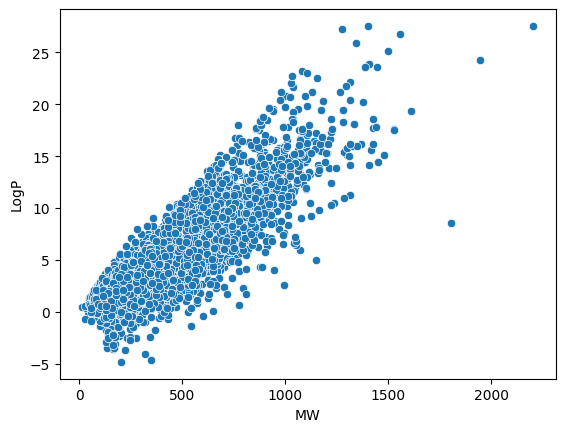

In [62]:
# Scatter plot example: MW vs LogP
sns.scatterplot(x='MW', y='LogP', data=df)

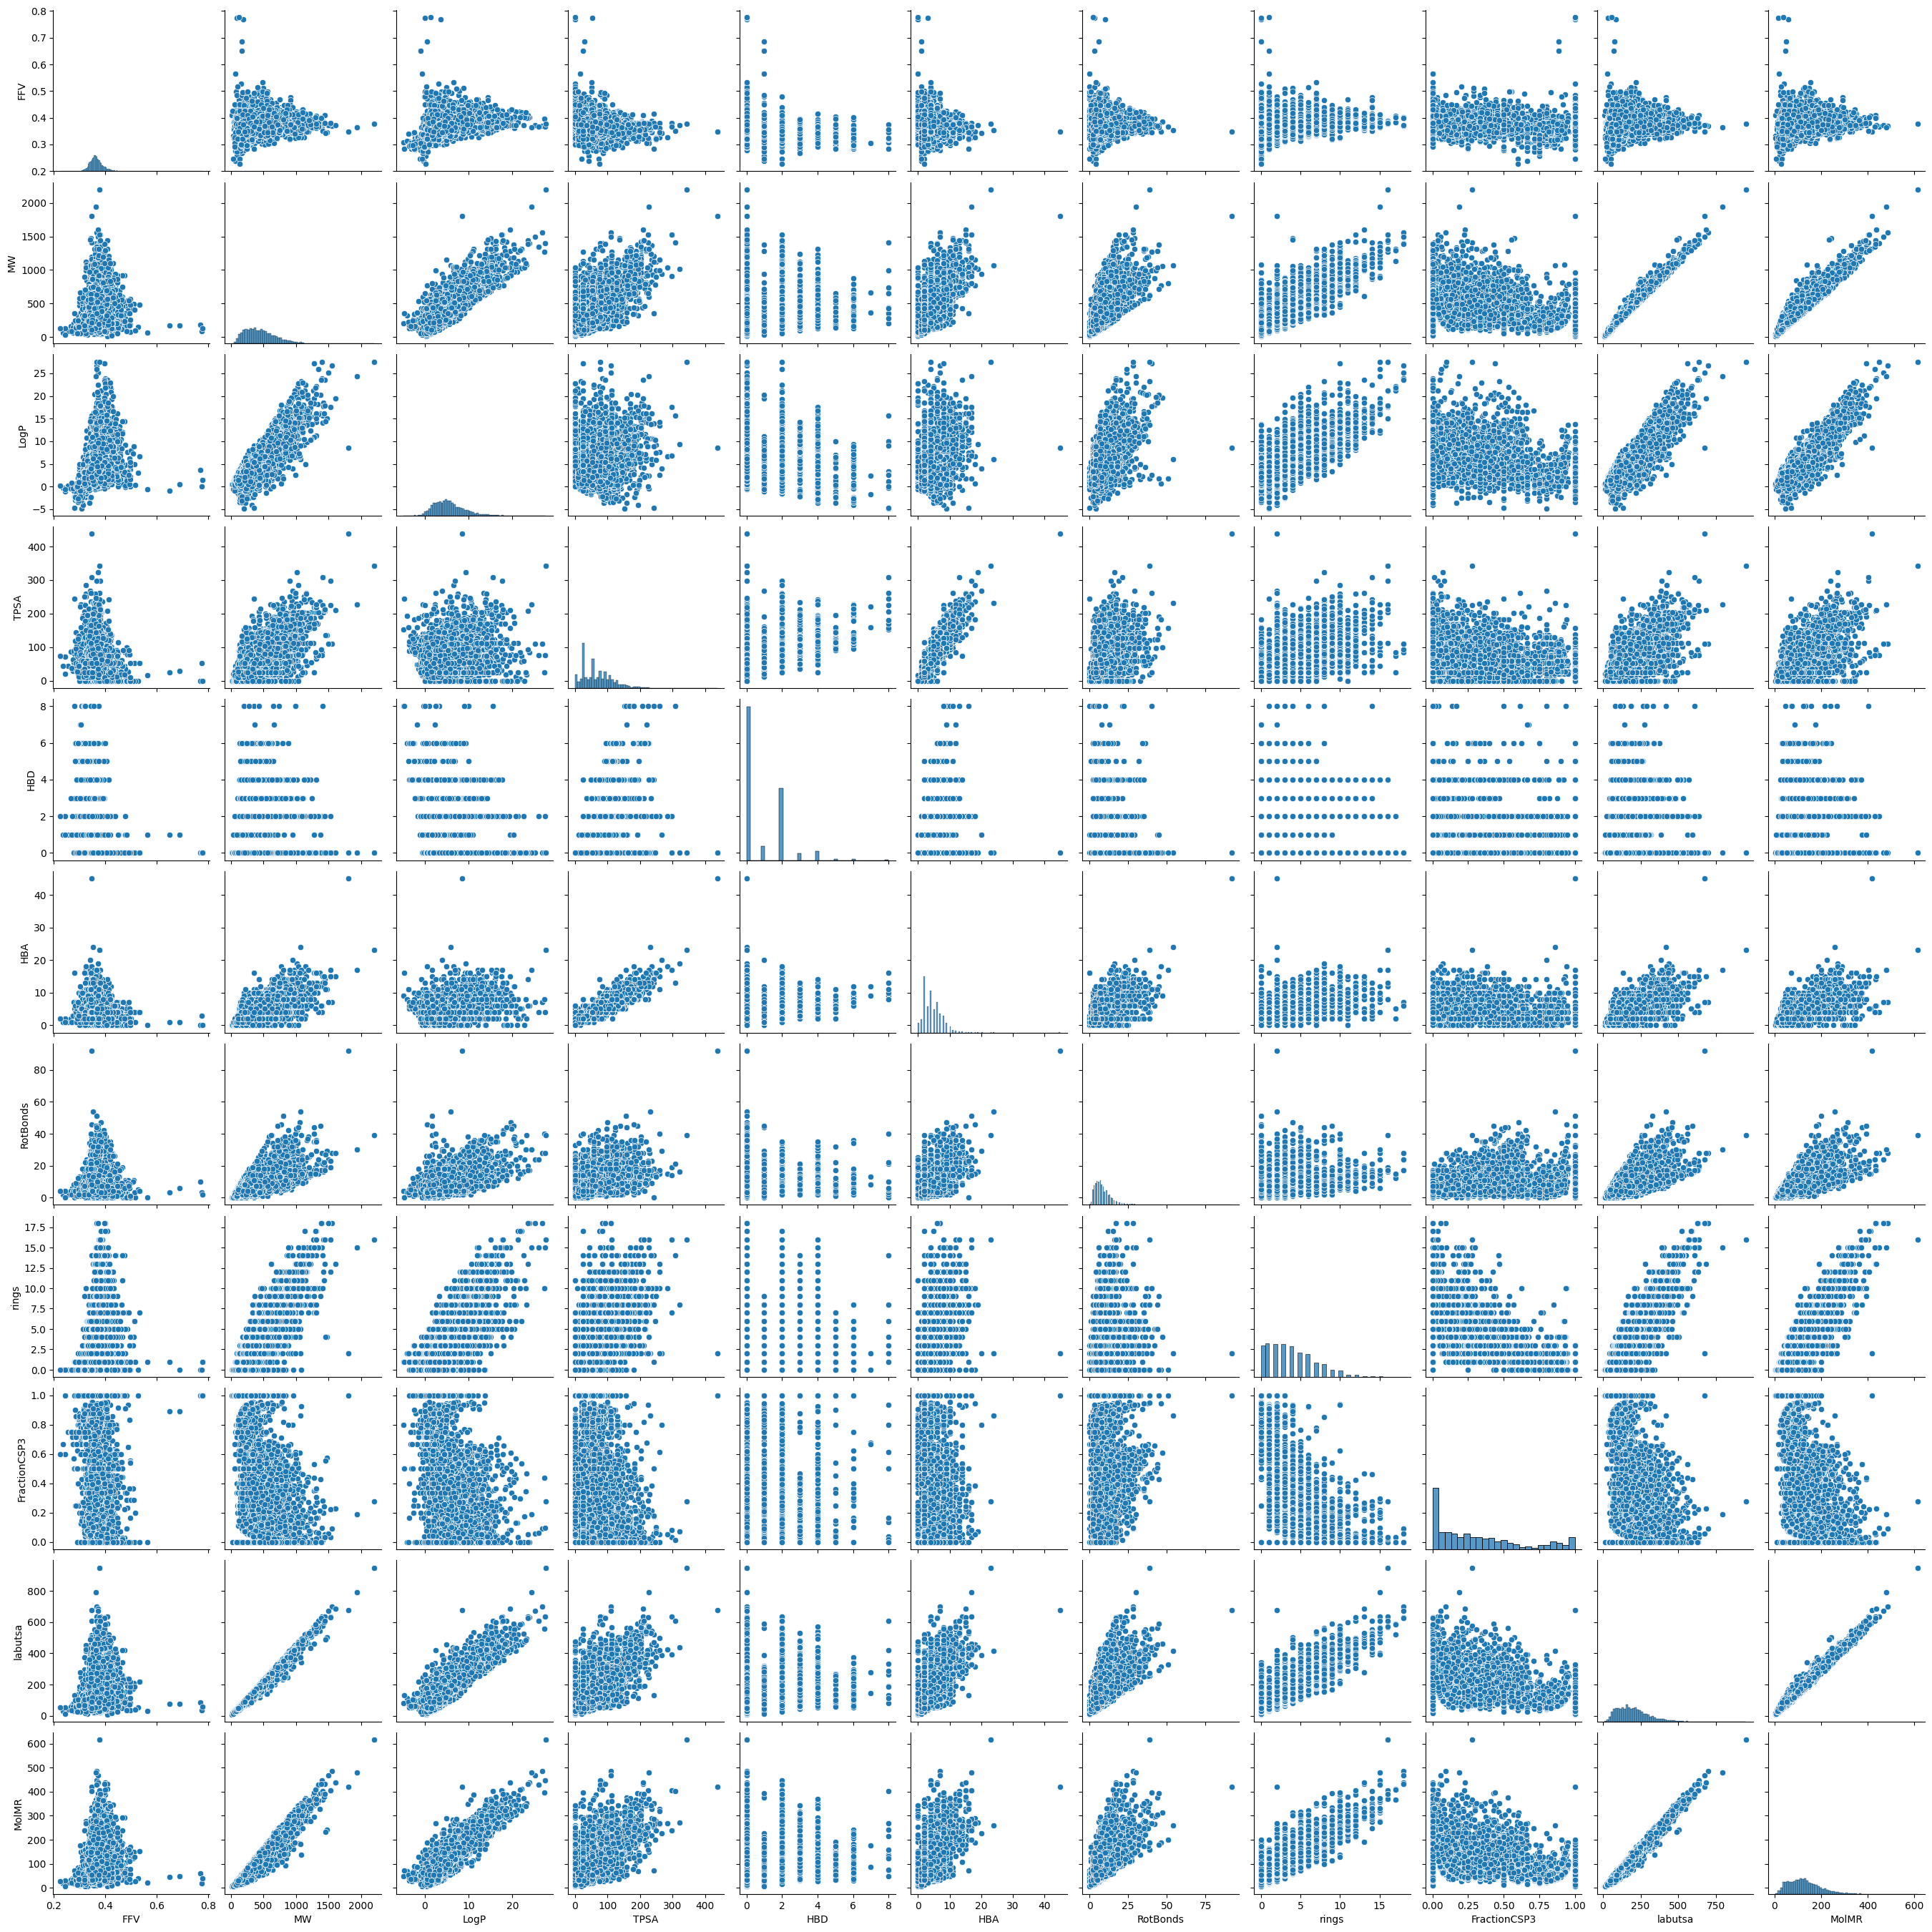

In [63]:
# Pairplot for all descriptors
sns.pairplot(df[descriptor_cols])

In [64]:
#dropping labutsa, HBA, HBD columns after EDA
df = df.drop(columns=['labutsa', 'HBA', 'HBD'], errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7030 entries, 0 to 7972
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7030 non-null   int64  
 1   SMILES            7030 non-null   object 
 2   FFV               7030 non-null   float64
 3   canonical_smiles  7030 non-null   object 
 4   molecule          7030 non-null   object 
 5   MW                7030 non-null   float64
 6   LogP              7030 non-null   float64
 7   TPSA              7030 non-null   float64
 8   RotBonds          7030 non-null   float64
 9   rings             7030 non-null   float64
 10  FractionCSP3      7030 non-null   float64
 11  MolMR             7030 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 714.0+ KB


In [65]:
# Generate EDA report for training set
profile = ProfileReport(df_train, title="EDA Report", explorative=True)
profile.to_notebook_iframe()
# Save to an html file
profile.to_file("FFV_eda_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 151.47it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
# Setting random seed for reproducibility
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)

In [67]:
#Checking rows with TPSA = 0 to check the validity of these rows in terms of physical meaning
df[df['TPSA']==0]

id                                             SMILES       FFV  \
35       8689461                             *CC(*)CCCCCCCCCCCCCCCC  0.407873   
41      10557152                              *C(C)=C(*)[Ge](C)(C)C  0.399961   
138     41386383                                   *CCCCCC(*)CCCCCC  0.406286   
147     44332410                                      *CC(*)CCCCCCC  0.405013   
183     54206705                       *C=C(*)C(CCCCCCC)[Si](C)(C)C  0.410606   
...          ...                                                ...       ...   
7806  2103439506                         *CCC[Si](*)(C)C[Si](C)(C)C  0.405079   
7807  2103456476                          *CC(*)c1ccc(CCCCCCCCC)cc1  0.399551   
7834  2111187299  *C(=Cc1ccc(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2...  0.397152   
7900  2127356325                          *c1cc(CCCCCCCCCCCC)c(*)s1  0.410225   
7961  2144585137                       *C=CCCCCCCCCCC(Cl)CCCCCCCCC*  0.404653   

                                       canonical_smiles  \
35                               *CC(*)CCCCCCCCCCCCCCCC   
41                  *C(C)=[C](*)[Ge]([CH3])([CH3])[CH3]   
138                                    *CCCCCC(*)CCCCCC   
147                                       *CC(*)CCCCCCC   
183                        *C=C(*)C(CCCCCCC)[Si](C)(C)C   
...                                                 ...   
7806                         *CCC[Si](*)(C)C[Si](C)(C)C   
7807                          *CC(*)c1ccc(CCCCCCCCC)cc1   
7834  *C(=Cc1ccc(C=C(c2ccccc2)c2ccc(-c3ccc(*)cc3)cc2...   
7900                          *c1cc(CCCCCCCCCCCC)c(*)s1   
7961                       *C=CCCCCCCCCCC(Cl)CCCCCCCCC*   

                                           molecule       MW    LogP  TPSA  \
35    <rdkit.Chem.rdchem.Mol object at 0x310403a70>  252.486  7.1632   0.0   
41    <rdkit.Chem.rdchem.Mol object at 0x310403e60>  156.772  2.1939   0.0   
138   <rdkit.Chem.rdchem.Mol object at 0x3103d0890>  168.324  4.8226   0.0   
147   <rdkit.Chem.rdchem.Mol object at 0x3103d0c80>  126.243  3.6523   0.0   
183   <rdkit.Chem.rdchem.Mol object at 0x3103d1c40>  210.437  4.9953   0.0   
...                                             ...      ...     ...   ...   
7806  <rdkit.Chem.rdchem.Mol object at 0x3107b8120>  172.420  3.3461   0.0   
7807  <rdkit.Chem.rdchem.Mol object at 0x3107b8190>  230.395  5.5377   0.0   
7834  <rdkit.Chem.rdchem.Mol object at 0x3107b8d60>  432.566  8.1645   0.0   
7900  <rdkit.Chem.rdchem.Mol object at 0x3107baa40>  250.451  4.5607   0.0   
7961  <rdkit.Chem.rdchem.Mol object at 0x3107bc580>  326.996  8.2561   0.0   

      RotBonds  rings  FractionCSP3    MolMR  
35        16.0    0.0      1.000000   83.486  
41         1.0    0.0      0.666667   36.046  
138       10.0    0.0      1.000000   55.784  
147        7.0    0.0      1.000000   41.933  
183        8.0    0.0      0.846154   68.555  
...        ...    ...           ...      ...  
7806       5.0    0.0      1.000000   54.002  
7807      10.0    1.0      0.647059   75.687  
7834       6.0    5.0      0.000000  145.682  
7900      11.0    1.0      0.750000   79.135  
7961      19.0    0.0      0.904762  102.077  

[331 rows x 12 columns]

In [68]:
#calculating properties of a given structure to compare to confirm teh dataset accuracy 
# id 8689461 with TPSA = 0

mol = Chem.MolFromSmiles("*CC(*)CCCCCCCCCCCCCCCC")  # Example molecule
print("TPSA:", rdMolDescriptors.CalcTPSA(mol))
print("Rings:", mol.GetRingInfo().NumRings())
print("FractionCSP3:", rdMolDescriptors.CalcFractionCSP3(mol))


#id 10557152 with TPSA = 0

mol = Chem.MolFromSmiles("*C(C)=[C](*)[Ge]([CH3])([CH3])[CH3]")  # Example molecule
print("TPSA:", rdMolDescriptors.CalcTPSA(mol))
print("Rings:", mol.GetRingInfo().NumRings())
print("FractionCSP3:", rdMolDescriptors.CalcFractionCSP3(mol))


TPSA: 0.0
Rings: 0
FractionCSP3: 1.0
TPSA: 0.0
Rings: 0
FractionCSP3: 0.6666666666666666


Starting splitting

In [72]:
# Splitting the dataset into training, testing, and validation sets
descriptor_features= ['MW', 'LogP', 'TPSA', 'RotBonds', 'rings','FractionCSP3', 'MolMR']
x = df[descriptor_features]
y = df['FFV']

x_train, x_test, y_train, y_test= train_test_split(
    x, y, test_size=0.15,  # 15% for testing
    random_state=RANDOM_SEED  # Ensure reproducibility
)
x_train, x_validation, y_train, y_validation = train_test_split(
    x, y,
    test_size=0.5,  # 50% of training set for validation
    random_state=RANDOM_SEED  # Ensure reproducibility
)

In [75]:
# Display the shape of all sets
print(f"Descriptors features Training set size: {x_train.shape}")
print(f"Descriptors features Validation set size: {x_validation.shape}")
print(f"Descriptors featres Test set size: {x_test.shape}")
print(f"FFV Training set size: {y_train.shape}")
print(f"FFV Validation set size: {y_validation.shape}")
print(f"FFV Test set size: {y_test.shape}")

Descriptors features Training set size: (3515, 7)
Descriptors features Validation set size: (3515, 7)
Descriptors featres Test set size: (1055, 7)
FFV Training set size: (3515,)
FFV Validation set size: (3515,)
FFV Test set size: (1055,)


In [77]:
#initializing the StandardScaler
scaler = StandardScaler()

#Fitting the scaler on training data only and transforming training, validation, and test sets
df_train_scaled = scaler.fit_transform(x_train)
df_validation_scaled = scaler.transform(x_validation)
df_test_scaled = scaler.transform(x_test)

In [ ]:
# PEarson and Spearman Correlation calculation
df_subsets = pd.concat([x_train, y_train], axis=1)
y_train = pd.Series(y_train, name='FFV')
pearson_corr = df_subsets.corr(method='pearson')['FFV']
sorted_pearson_corr = pearson_corr.sort_values(ascending=False)
print("Pearson Correlation with FFV:")
print(sorted_pearson_corr)
print("\n")

spearman_corr = df_subsets.corr(method='spearman')['FFV']
sorted_spearman_corr = spearman_corr.sort_values(ascending=False)
print("Spearman Correlation with FFV:")
print(sorted_spearman_corr)

Pearson Correlation with FFV:
FFV             1.000000
LogP            0.283889
rings           0.215727
MolMR           0.195002
MW              0.145201
RotBonds       -0.048436
FractionCSP3   -0.057889
TPSA           -0.218830
Name: FFV, dtype: float64


Spearman Correlation with FFV:
FFV             1.000000
LogP            0.366574
rings           0.280501
MolMR           0.260722
MW              0.206176
RotBonds       -0.059698
FractionCSP3   -0.102541
TPSA           -0.241677
Name: FFV, dtype: float64


🔍 Observations
Many relationships are nonlinear
You can see curved or cloud-like scatter patterns rather than straight-line trends — especially between FFV and descriptors like LogP, TPSA, and MW.
→ This means the relationship isn’t strictly linear.
Some variables have discrete levels
Variables like rings, RotBonds, and perhaps HBD appear as discrete steps rather than continuous values.
→ That violates the assumption of linearity that Pearson requires.
Skewed distributions
Several descriptors show right-skewed histograms (e.g., MW, TPSA).
→ These are not normally distributed — another reason Pearson correlation may be less reliable.
Possible monotonic patterns
Even though they’re not linear, you can often see monotonic trends (as one variable increases, FFV tends to increase or decrease overall).
→ This suits Spearman correlation.
🧠 Interpretation
Pearson correlation assumes:
Linear relationships
Continuous numeric variables
Roughly normal distributions
Spearman correlation:
Works on ranked data
Captures monotonic (not necessarily linear) relationships
Robust to outliers and non-normality
✅ Conclusion
From your pairplot, your data clearly show nonlinear and discrete patterns in some predictors.
👉 Spearman correlation is more appropriate for this dataset.
It will give a more realistic view of how descriptors like LogP, MW, and TPSA relate to FFV, since it measures rank-based monotonicity instead of strict linear dependence.

In [98]:
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor(strategy='median')

In [99]:
# Fit Dummy Regressors
dummyregressor_mean.fit(x_train, y_train)
dummyregressor_median.fit(x_train, y_train)

DummyRegressor(strategy='median')

In [ ]:
# Evaluate Dummy Regressors
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = model.predict(X)
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    maximum_error = max_error(y_true, y_predicted)
    mape =  mean_absolute_percentage_error(y_true, y_predicted)

    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error,
        'mape': mape
    }

    return metrics_dict
    y_predicted.shape()


In [ ]:
# Dictionaries to store results
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [ ]:
#Calculating metrics for dummy regressors
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, x_test, y_test)
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, x_train, y_train)

Calculating metrics for mean
Calculating metrics for median


In [ ]:
# Final predictions using median dummy regressor
test = dummyregressor_median.predict(x_test)

In [ ]:
# Printing results of dummy regressors
print("Dummy Regressor Results - Train & Test Set")

for regressorname, metrics in dummy_regressor_results_train.items():
    print(f"{regressorname} (Train): {metrics}")

for regressorname, metrics in dummy_regressor_results_test.items():
    print(f"{regressorname} (Test): {metrics}")


Dummy Regressor Results - Train & Test Set
mean (Train): {'mae': 0.021266000872804825, 'mse': 0.000937494537112107, 'max_error': 0.40954557711948786, 'mape': 0.05739695479884564}
median (Train): {'mae': 0.021118434675675677, 'mse': 0.000945897943112118, 'max_error': 0.41244443999999997, 'mape': 0.056543848725389804}
mean (Test): {'mae': 0.020465532259281483, 'mse': 0.0007755880046613762, 'max_error': 0.1493127071194879, 'mape': 0.05539736527525308}
median (Test): {'mae': 0.020255335530805683, 'mse': 0.0007830127562898246, 'max_error': 0.15221157000000002, 'mape': 0.054389550815871636}
